In [49]:
# Pre compute solar zenith angle and azimuth maps for a given zarr dataset

import os
import numpy as np
import pandas as pd
import xarray
from dask.distributed import Client
from preprocess.sza import solarzenithangle
from tqdm import tqdm

In [50]:
client = Client(n_workers=12)

/scratch/snx3000/kschuurm/lightning/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45955 instead
  warnings.warn(


In [51]:
seviri = xarray.open_zarr(
    "/scratch/snx3000/kschuurm/ZARR/SEVIRI_FULLDISK.zarr"
).drop_duplicates(dim="time")
seviri = seviri.rename_dims({"x": "lon", "y": "lat"}).rename_vars({"x": "lon", "y": "lat"})
seviri

<xarray.Dataset>
Dimensions:      (time: 222290, lat: 658, lon: 736)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 ... 2022-12-31T23:45:00
  * lon          (lon) float64 -7.775 -7.725 -7.675 -7.625 ... 28.88 28.93 28.98
  * lat          (lat) float64 28.98 29.03 29.08 29.12 ... 61.73 61.78 61.83
Data variables:
    IR_016       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_039       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_087       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_097       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_108       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_120       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_134       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    VIS006       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    VIS008       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    WV_062       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    WV_073       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    spatial_ref  int64 ...

In [52]:
lat = seviri.lat.copy()
lon = seviri.lon.copy()

In [33]:
import concurrent
from functools import partial


def test(lat, datetimes, lons):
    szas = []
    azis = []
    for j, lon in enumerate(lons):
        sza, azi = solarzenithangle(datetimes, lat, lon, 0)
        azis.append(azi)
        szas.append(sza)
    return szas, azis


def solarzenithangle_latlon(ds):
    datetimes = pd.to_datetime(ds.time)

    # subsample per lat/lon degree
    lats = np.arange(ds.lat.min(), ds.lat.max() + 1, 0.5, dtype=np.float32)
    lons = np.arange(ds.lon.min(), ds.lon.max() + 1, 0.5, dtype=np.float32)

    da_sza = xarray.DataArray(
        coords={
            "time": datetimes,
            "lat": lats,
            "lon": lons,
        },
        data=np.zeros(shape=(len(datetimes), len(lats), len(lons)), dtype=np.float16),
    )
    da_sza.name = "SZA"
    da_sza.attrs.update(
        {
            "long_name": "Solar Zenith Angle at sea level",
            "standard_name": "solar_zenith_angle",
            "units": "rad",
        }
    )
    da_azi = xarray.DataArray(
        coords={
            "time": datetimes,
            "lat": lats,
            "lon": lons,
        },
        data=np.zeros(shape=(len(datetimes), len(lats), len(lons)), dtype=np.float16),
    )
    da_azi.name = "AZI"
    da_azi.attrs.update(
        {
            "long_name": "Solar Azimuth Angle at sea level",
            "standard_name": "solar_azimuth_angle",
            "units": "rad",
        }
    )

    test2 = partial(test, datetimes=datetimes, lons=lons)

    with concurrent.futures.ProcessPoolExecutor() as pool:
        szas, azis = zip(*tqdm(pool.map(test2, lats), total=len(lats)))

    szas = np.array(szas)
    azis = np.array(azis)
    print(szas.shape, azis.shape)
    print(len(lats), len(lons), len(datetimes))

    ds = xarray.Dataset(
        data_vars={
            "SZA": (("lat", "lon", "time"), szas),
            "AZI": (("lat", "lon", "time"), azis),
        },
        coords=dict(lon=(["lon"], lons), lat=(["lat"], lats), time=datetimes),
    )

    return ds

In [ ]:
ds_sun = solarzenithangle_latlon(seviri)
ds_sun

In [ ]:
ds_sun.to_zarr("temp.zarr", mode="w")

In [42]:
temp = xarray.open_zarr("temp.zarr")
for var in temp:
    del temp[var].encoding["chunks"]

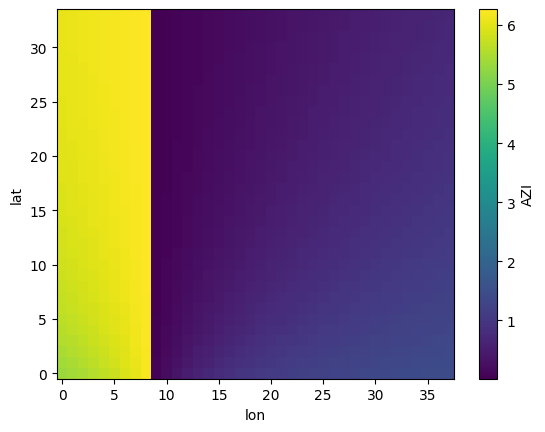

In [43]:
temp.isel(time=0).AZI.plot.imshow()

In [8]:
temp.chunk({"time": 60, "lat": -1, "lon": -1}).to_zarr("temp2.zarr", mode="w")

In [62]:
temp2 = xarray.open_zarr("temp2.zarr")
# temp2.isel(time=0).AZI.plot.imshow()

lats = np.arange(seviri.lat.min(), seviri.lat.max() + 1, 1, dtype=np.float32)
lons = np.arange(seviri.lon.min(), seviri.lon.max() + 1, 1, dtype=np.float32)
datetimes= pd.to_datetime(seviri.time)

ds_sun = xarray.Dataset(
            data_vars=dict(
                AZI=(('time','lat','lon',),temp2.AZI.data), 
                SZA=(('time','lat','lon',),temp2.SZA.data)),
            coords=dict(
                lon=(["lon"], lons),
                lat=(["lat"], lats),
                time=datetimes)
        )

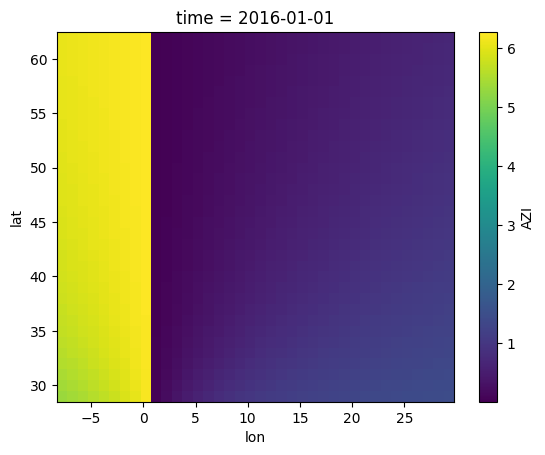

In [64]:
ds_sun.AZI.isel(time=0).plot.imshow()

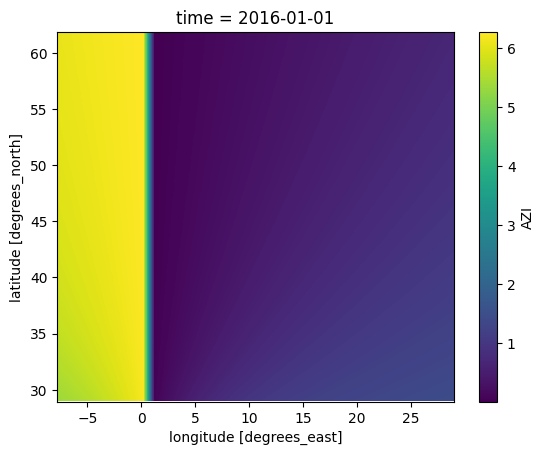

In [66]:
ds_sun_interp = ds_sun.interp(lat=seviri.lat, lon=seviri.lon)
ds_sun_interp.AZI.isel(time=0).plot.imshow()

In [67]:
temp2 = ds_sun_interp.to_zarr("/scratch/snx3000/kschuurm/ZARR/SOLARPOS.zarr", mode="w")

In [ ]:
os.rmdir("temp.zarr")
os.rmdir("temp2.zarr")

In [ ]:
ds_sun_final.to_zarr("/scratch/snx3000/kschuurm/ZARR/SOLARPOS.zarr", mode="a")